In [2]:
# !pip install scikit-image

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [5]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

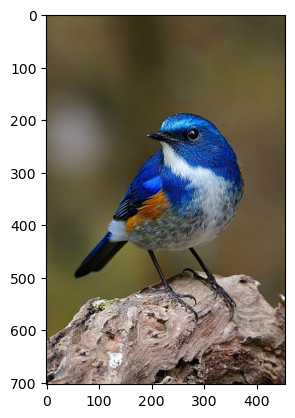

In [6]:
plt.imshow(image)
plt.show()

In [7]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [8]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [9]:
image_array.shape

(703, 454, 3)

In [10]:
image_array = image_array.reshape((1,) + image_array.shape)

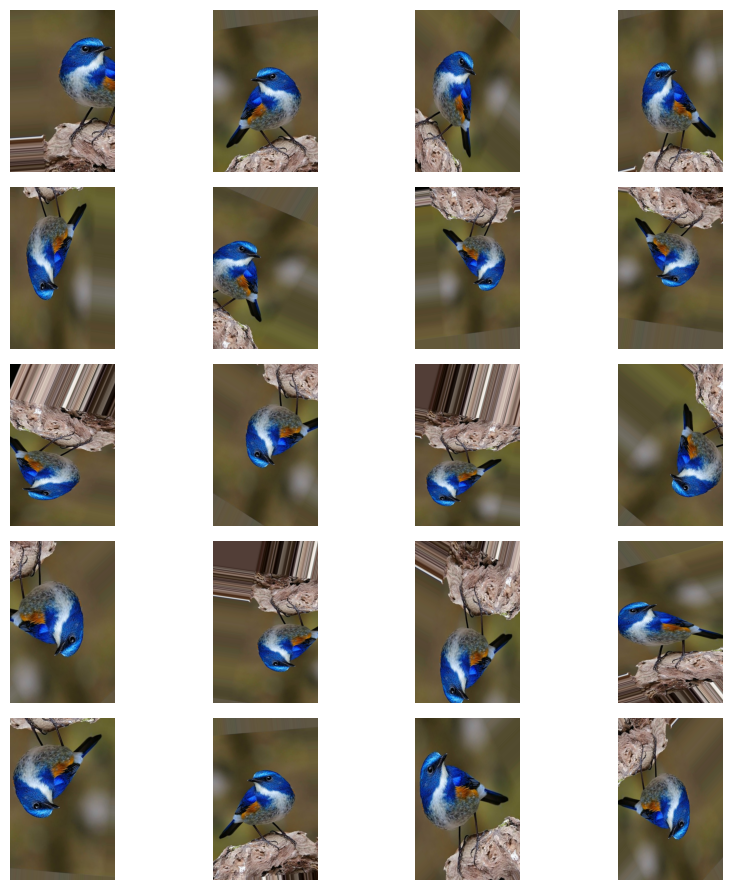

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [12]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2
import tensorflow as tf

# GPU 디바이스 설정
# tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [13]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

2024-09-13 12:20:29.329766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 12:20:29.331222: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) RX Vega 11 Graphics)
2024-09-13 12:20:29.461139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:20:29.461198: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-09-13 12:20:29.461230: I tensorflow/core/common_runtime/pluggable_device/pluggab

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
# model.summary()

In [16]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [17]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [18]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [19]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [20]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-13 12:20:45.813928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 12:20:46.420284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:20:46.420357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4831 

2024-09-13 12:21:03.808881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 12:21:04.815460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:21:04.815580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - 39s 23s/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6930 - val_accuracy: 0.5299
Epoch 2/2000
2/2 [==============================] - 24s 16s/step - loss: 0.6931 - accuracy: 0.5273 - val_loss: 0.6929 - val_accuracy: 0.5273
Epoch 3/2000
2/2 [==============================] - 21s 15s/step - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 4/2000
2/2 [==============================] - 23s 16s/step - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 5/2000
2/2 [==============================] - 25s 17s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6927 - val_accuracy: 0.5273
Epoch 6/2000
2/2 [==============================] - 23s 15s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 7/2000
2/2 [==============================] - 21s 14s/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 8/2000
2/2 [========

KeyboardInterrupt: 

# Resnet

In [ ]:
base_model2 = ResNet152V2(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

In [ ]:
base_model2.summary()

In [ ]:
base_model2.trainable = False
model2 = Sequential()
model2.add(base_model2)
model2.add(Dense(2, activation='sigmoid'))
# model.summary()

In [ ]:
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [ ]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [26]:
history2=model2.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
res50_model = load_model("./model/Resnet50_catndog.keras")

In [ ]:
res50_pred = res50_model.predict(valid_gen)
res50_pred

In [ ]:
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_gen))
pred_values = np.argmax(res50_pred, axis=1)

In [ ]:
pred_values

In [ ]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[] )
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    if pred_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[pred_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[pred_values[i]], color='red', fontsize=14)

# resnet152V2

In [ ]:
res152V2_model = load_model("./model/Resnet152V2_catndog.keras")

In [ ]:
res152V2_pred = res152V2_model.predict(valid_gen)
validation, label_batch = next(iter(valid_gen))
pred_values = np.argmax(res152V2_pred, axis=1)
pred_values

In [ ]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[] )
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    if pred_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[pred_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[pred_values[i]], color='red', fontsize=14)

# 텐서플로 허브에서 사전 훈련된 모델 받아서 개와 고양이 판별하기

In [ ]:
# !pip install --upgrade tensorflow_hub

In [ ]:
import tensorflow_hub as hub

In [ ]:
model = Sequential()
model.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
                   input_shape=(224, 224, 3),
                   trainable=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_tensor_hub_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [ ]:
history = model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

In [ ]:
Resnet152V2_catndog = load_model("./model/Resnet152V2_catndog.keras")

In [ ]:
model_pred = Resnet152V2_catndog.predict(valid_gen)
validation, label_batch = next(iter(valid_gen))
pred_values = np.argmax(model_pred, axis=1)
pred_values

In [ ]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[] )
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    if pred_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[pred_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[pred_values[i]], color='red', fontsize=14)